<a href="https://colab.research.google.com/github/threegenie/sentiment_project/blob/main/sentiment_project_using_okt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Okt, GRU, LSTM을 이용하여 감성분석 해보기

In [2]:
! pip install konlpy

In [3]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 3s (3,093 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 160772 files and d

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
#mpl.font_manager._rebuild()

# https://pinkwink.kr/1255 / https://teddylee777.github.io/colab/colab-korean 한글 문제 대응 참고

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [6]:
# 오류(SettingWithCopyError 발생)
pd.set_option('mode.chained_assignment', 'raise') # SettingWithCopyError

# 경고(SettingWithCopyWarning 발생, 기본 값입니다)
pd.set_option('mode.chained_assignment', 'warn') # SettingWithCopyWarning

# 무시
pd.set_option('mode.chained_assignment',  None) # <==== 경고를 끈다

In [9]:
df = pd.read_table('review.txt', names=['ratings', 'reviews'])
df

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ
...,...,...
199995,2,장마라그런가!!! 달지않아요
199996,5,다이슨 케이스 구매했어요 다이슨 슈퍼소닉 드라이기 케이스 구매했어요가격 괜찮고 배송...
199997,5,로드샾에서 사는것보다 세배 저렴하네요 ㅜㅜ 자주이용할께요
199998,5,넘이쁘고 쎄련되보이네요~


#### 중복 데이터가 있다면 제거

In [10]:
df.drop_duplicates('reviews',keep='first')
df.shape

(200000, 2)

중복 데이터가 없다.

#### 별이 3개인 어중간한 데이터 제거

In [11]:
three = df[df['ratings']==3].index
df = df.drop(three)
df.shape

(200000, 2)

별 3개인 데이터가...없다...?!

#### 훈련, 테스트셋 분리

In [12]:
train, val = train_test_split(df, test_size = 0.2, random_state = 11)
train.shape, val.shape

((160000, 2), (40000, 2))

#### 별점으로 라벨링 : 별점이 4을 넘으면 긍정 리뷰, 이하는 부정 리뷰로 분류

In [13]:
def star_evaluate(rating):
  if rating >=4:
    return 1
  else:
    return 0
  
train['label'] = train['ratings'].apply(star_evaluate)
val['label'] = val['ratings'].apply(star_evaluate)
train

,ratings,reviews,label
6173,5,머리끝이 많이 갈라져서 구매했습니다. 이미 갈라진 건 어쩔 수 없지만 뭔가 모발이 ...,1
62572,4,"가방사이즈 딱 적절해서 좋고, 탄탄한 느낌이라 좋네요. 다만 새것 냄새가 2일째 빠...",1
102317,2,생각보다 짧아요 ㅠ,0
122006,2,별로따뜻하지도않고..벨브도돌리다밑에캡이빠져버리네여..ㅡㅡ그래서본드로붙였는데..노즐만...,0
111083,1,마스크는소형인데끈이대형이네요ㅎ 그것도 쉽게 끊어져요ㅜ,0
...,...,...,...
102327,1,완전 잘깨져요 이건 뭐 잠깐 바닥에 스치기만해도 깨져있어요,0
97617,2,바코드안떳어요,0
21584,2,네조아요. 필요해서 샀어요,0
36543,5,발열 엄청 오래 지속되고 냄새도 없고 만족합니다,1


In [14]:
train['label'].value_counts()

0    80157
1    79843
Name: label, dtype: int64

#### 데이터 정제 - 훈련, 테스트셋에 모두 적용 -> 정규표현식 사용하여 한글 제외 모두 제거

In [15]:
train['reviews'] = train['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train['reviews'].replace('', np.nan, inplace=True)
train.head()

,ratings,reviews,label
6173,5,머리끝이 많이 갈라져서 구매했습니다 이미 갈라진 건 어쩔 수 없지만 뭔가 모발이 더...,1
62572,4,가방사이즈 딱 적절해서 좋고 탄탄한 느낌이라 좋네요 다만 새것 냄새가 일째 빠지지 ...,1
102317,2,생각보다 짧아요 ㅠ,0
122006,2,별로따뜻하지도않고벨브도돌리다밑에캡이빠져버리네여ㅡㅡ그래서본드로붙였는데노즐만새로사야할듯...,0
111083,1,마스크는소형인데끈이대형이네요ㅎ 그것도 쉽게 끊어져요ㅜ,0


In [16]:
val['reviews'] = val['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
val['reviews'].replace('', np.nan, inplace=True)
val.head()

,ratings,reviews,label
126682,5,조립하기힘들었어요 나사가짧아서,1
64852,2,ㅜㅜ 제가 인데 ㅜㅜ 진짜 너무너무커요 빨으니까 더 커졌어요ㅜ 잠옷으로 입으려구요,0
139941,1,만족하는데 배송이 개느림,0
85091,5,허리받쳐주는건 좋은데 방석이 미끌어져서 뷸편하네용 ㅠ,1
61522,5,밥을 해도 압력이 안된 밥을 먹었는데 새 패킹으로 갈아끼우니 짱짱하네여내일부터는 밥...,1


#### 토큰화 - Okt 사용

In [17]:
from konlpy.tag import Okt
okt = Okt()

In [18]:
stopwords = ['요', '도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [19]:
train['tokenized'] = train['reviews'].apply(okt.morphs)
train['tokenized'] = train['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [20]:
val['tokenized'] = val['reviews'].apply(okt.morphs)
val['tokenized'] = val['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [21]:
train.head()

,ratings,reviews,label,tokenized
6173,5,머리끝이 많이 갈라져서 구매했습니다 이미 갈라진 건 어쩔 수 없지만 뭔가 모발이 더...,1,"[머리, 끝, 많이, 갈라져서, 구매, 했습니다, 이미, 갈라진, 건, 어쩔, 수,..."
62572,4,가방사이즈 딱 적절해서 좋고 탄탄한 느낌이라 좋네요 다만 새것 냄새가 일째 빠지지 ...,1,"[가방, 사이즈, 딱, 적절해서, 좋고, 탄탄한, 느낌, 이라, 좋네요, 다만, 새..."
102317,2,생각보다 짧아요 ㅠ,0,"[생각, 보다, 짧아요, ㅠ]"
122006,2,별로따뜻하지도않고벨브도돌리다밑에캡이빠져버리네여ㅡㅡ그래서본드로붙였는데노즐만새로사야할듯...,0,"[별로, 따뜻하지도, 않고, 벨브, 돌리다, 밑, 캡, 빠져, 버리네, 여, ㅡㅡ,..."
111083,1,마스크는소형인데끈이대형이네요ㅎ 그것도 쉽게 끊어져요ㅜ,0,"[마스크, 소형, 인데, 끈, 이대형, 이네, ㅎ, 그것, 쉽게, 끊어져요, ㅜ]"


#### 단어 빈도에 따른 시각화 - Counter, Wordcloud 패키지 이용

In [22]:
negative_words = np.hstack(train[train.label == 0]['tokenized'].values)
positive_words = np.hstack(train[train.label == 1]['tokenized'].values)

In [23]:
nw = Counter(negative_words)
print(nw.most_common(20))

[('너무', 14161), ('안', 12449), ('배송', 9771), ('그냥', 9085), ('잘', 8416), ('로', 6177), ('했는데', 5988), ('별로', 5967), ('못', 5485), ('제품', 5419), ('으로', 5306), ('생각', 5276), ('좀', 5217), ('ㅠㅠ', 5191), ('사용', 5173), ('하고', 5035), ('보다', 4934), ('구매', 4878), ('만', 4227), ('맛', 4210)]


In [24]:
nwc = nw.most_common(15)

In [25]:
! pip install wordcloud

{'너무': 14161, '안': 12449, '배송': 9771, '그냥': 9085, '잘': 8416, '로': 6177, '했는데': 5988, '별로': 5967, '못': 5485, '제품': 5419, '으로': 5306, '생각': 5276, '좀': 5217, 'ㅠㅠ': 5191, '사용': 5173}


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


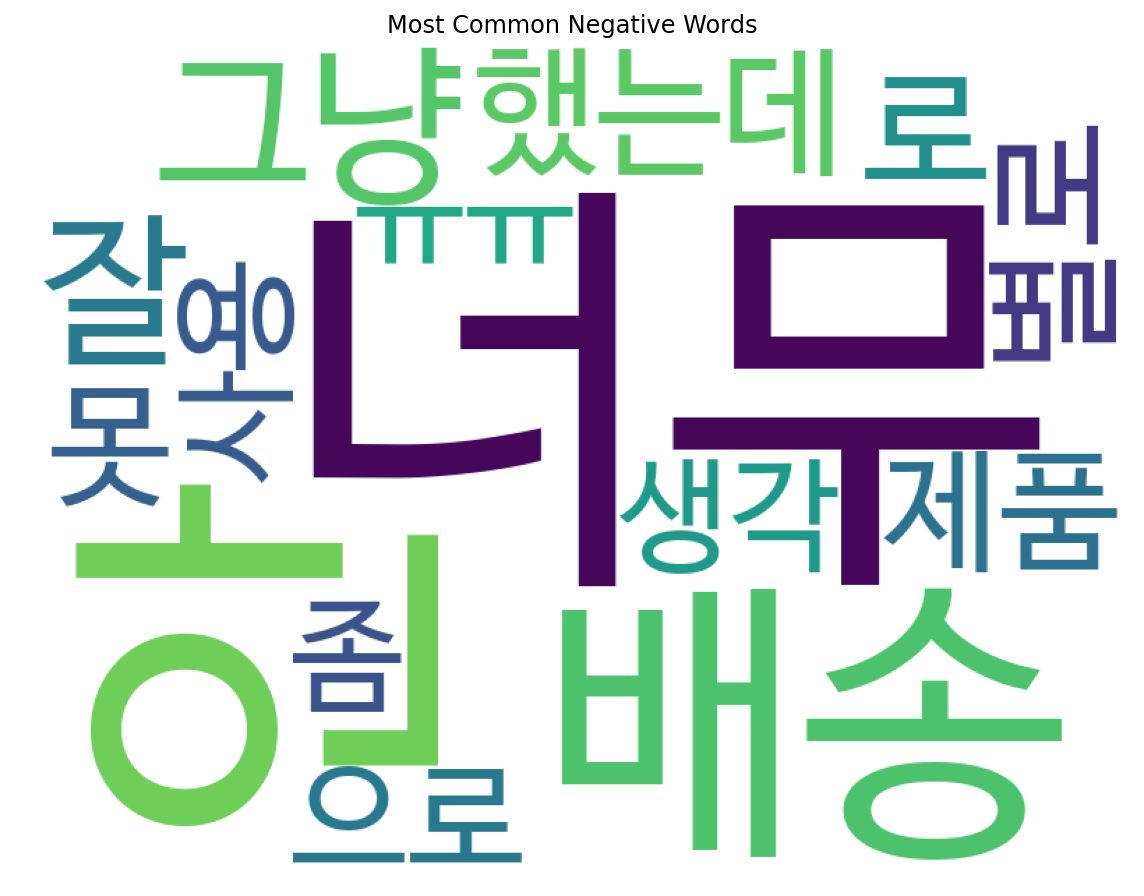

In [26]:
from wordcloud import WordCloud

#wordCloud생성
#한글꺠지는 문제 해결하기위해 font_path 지정
negative_word_cloud = WordCloud(font_path=fontpath, 
               background_color='white', width=800, height=600)
print(dict(nwc))
cloud = negative_word_cloud.generate_from_frequencies(dict(nwc))
plt.figure(figsize=(10, 8))
plt.title('Most Common Negative Words')
plt.axis('off')
plt.imshow(cloud)
plt.show()

In [27]:
pw = Counter(positive_words)
print(pw.most_common(20))

[('잘', 16320), ('좋아요', 15337), ('배송', 12884), ('너무', 9712), ('재구매', 9184), ('구매', 7629), ('사용', 5850), ('가격', 5346), ('같아요', 4747), ('으로', 4682), ('로', 4661), ('좋네요', 4471), ('제품', 4228), ('보다', 4209), ('빠르고', 4190), ('주문', 4070), ('입니다', 4007), ('생각', 3702), ('더', 3548), ('좋습니다', 3541)]


In [28]:
pwc = pw.most_common(15)

{'잘': 16320, '좋아요': 15337, '배송': 12884, '너무': 9712, '재구매': 9184, '구매': 7629, '사용': 5850, '가격': 5346, '같아요': 4747, '으로': 4682, '로': 4661, '좋네요': 4471, '제품': 4228, '보다': 4209, '빠르고': 4190}


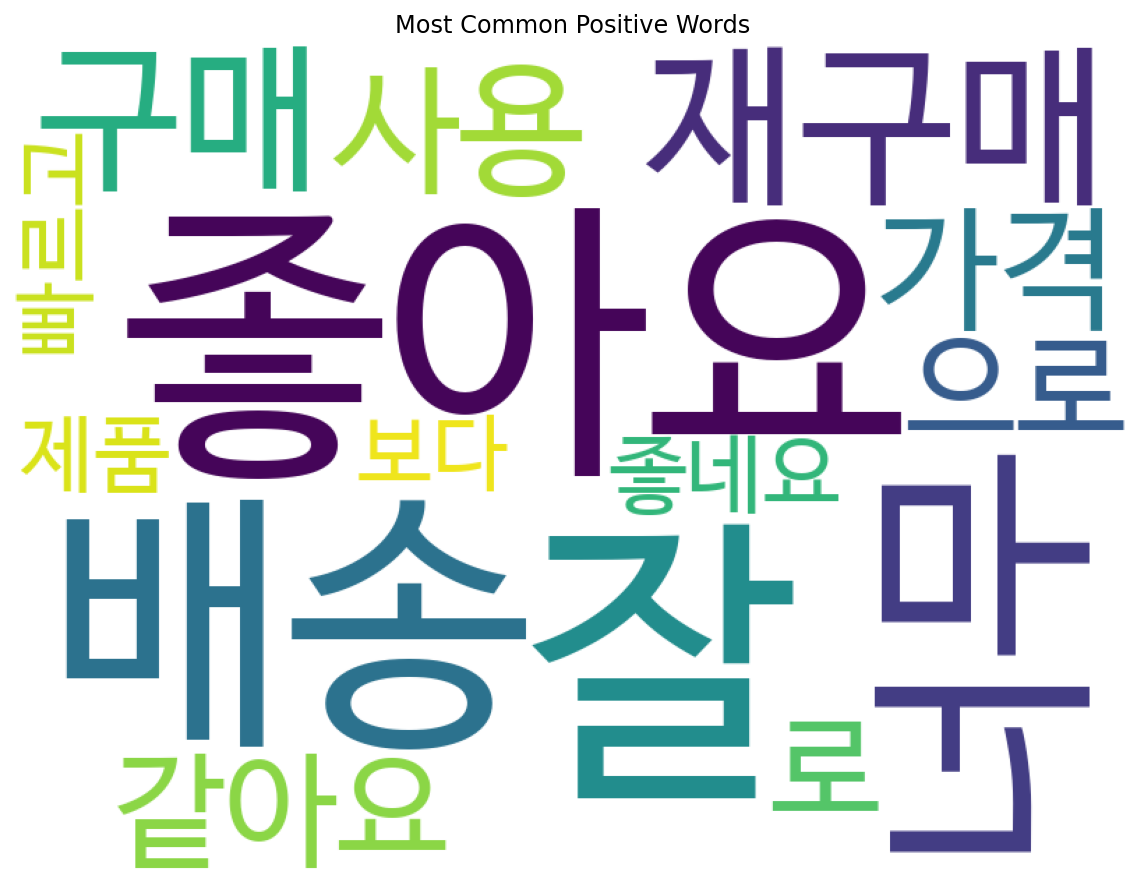

In [29]:
positive_word_cloud = WordCloud(font_path=fontpath, 
               background_color='white', width=800, height=600)
print(dict(pwc))
cloud = positive_word_cloud.generate_from_frequencies(dict(pwc))
plt.figure(figsize=(10, 8))
plt.title('Most Common Positive Words')
plt.axis('off')
plt.imshow(cloud)
plt.show()

#### 데이터에 정수 인코딩

In [30]:
X_train = train['tokenized']
y_train = train['label']
X_val= val['tokenized']
y_val = val['label']

In [31]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [32]:
threshold = 2
total_cnt = len(tokenizer.word_index) 
rare_cnt = 0 
total_freq = 0 
rare_freq = 0 

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 97950
등장 빈도가 1번 이하인 희귀 단어의 수: 54340
단어 집합에서 희귀 단어의 비율: 55.47728432873915
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.757317496432841


In [33]:
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 43612


In [34]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_val= tokenizer.texts_to_sequences(X_val)

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


리뷰의 최대 길이 : 59
리뷰의 평균 길이 : 12.317225


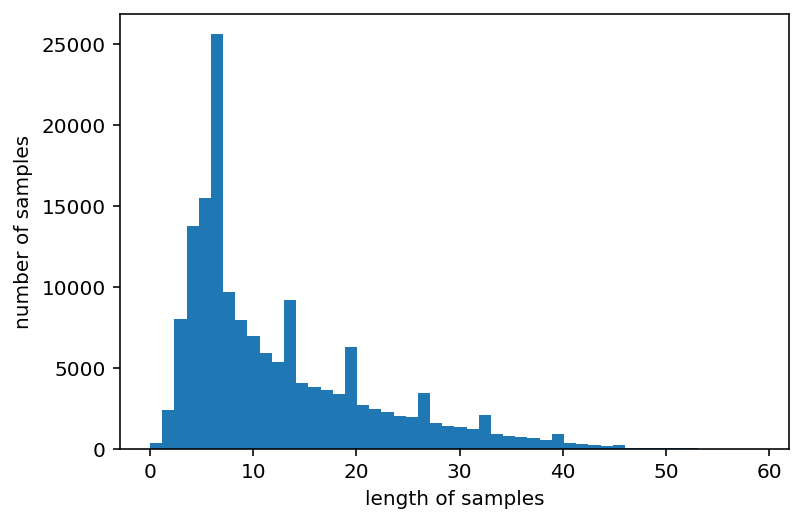

In [35]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [36]:
max_len = 80 #Padding 80으로
X_train = pad_sequences(X_train, maxlen = max_len)
X_val = pad_sequences(X_val, maxlen = max_len)


#### GRU 모델을 이용한 감성 분석

In [37]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [38]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(GRU(128))
model.add(Dense(1, activation='relu'))

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         4361200   
_________________________________________________________________
gru (GRU)                    (None, 128)               88320     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 4,449,649
Trainable params: 4,449,649
Non-trainable params: 0
_________________________________________________________________


In [40]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [41]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
2134/2134 [==============================] - 97s 42ms/step - loss: 0.4915 - acc: 0.8743 - val_loss: 0.4012 - val_acc: 0.8977

Epoch 00001: val_acc improved from -inf to 0.89772, saving model to best_model.h5
Epoch 2/15
2134/2134 [==============================] - 89s 42ms/step - loss: 0.4183 - acc: 0.9072 - val_loss: 0.4295 - val_acc: 0.9093

Epoch 00002: val_acc improved from 0.89772 to 0.90931, saving model to best_model.h5
Epoch 3/15
2134/2134 [==============================] - 89s 42ms/step - loss: 0.3726 - acc: 0.9183 - val_loss: 0.4749 - val_acc: 0.9104

Epoch 00003: val_acc improved from 0.90931 to 0.91037, saving model to best_model.h5
Epoch 4/15
2134/2134 [==============================] - 88s 41ms/step - loss: 0.3433 - acc: 0.9252 - val_loss: 0.4438 - val_acc: 0.9099

Epoch 00004: val_acc did not improve from 0.91037
Epoch 5/15
2134/2134 [==============================] - 88s 41ms/step - loss: 0.3028 - acc: 0.9323 - val_loss: 0.3885 - val_acc: 0.9128

Epoch 00005: 

#### LSTM 모델을 이용한 감성 분석

In [42]:
from tensorflow.keras.layers import LSTM, Bidirectional

model_lstm = Sequential()
model_lstm.add(Embedding(vocab_size, 100))
model_lstm.add(LSTM(100)) #Bidirectional drop
model_lstm.add(Dense(1, activation='relu')) #activation = sigmoid -> relu

In [43]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         4361200   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 4,441,701
Trainable params: 4,441,701
Non-trainable params: 0
_________________________________________________________________


In [44]:
es_lstm = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc_lstm = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [47]:
model_lstm.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
2134/2134 [==============================] - 88s 41ms/step - loss: 0.2797 - acc: 0.9742 - val_loss: 1.0265 - val_acc: 0.9019

Epoch 00001: val_acc did not improve from 0.91481
Epoch 2/15
2134/2134 [==============================] - 88s 41ms/step - loss: 0.2739 - acc: 0.9752 - val_loss: 1.0494 - val_acc: 0.8963

Epoch 00002: val_acc did not improve from 0.91481
Epoch 3/15
2134/2134 [==============================] - 88s 41ms/step - loss: 0.2722 - acc: 0.9769 - val_loss: 1.2365 - val_acc: 0.8906

Epoch 00003: val_acc did not improve from 0.91481
Epoch 4/15
2134/2134 [==============================] - 89s 42ms/step - loss: 0.2691 - acc: 0.9779 - val_loss: 1.1878 - val_acc: 0.8982

Epoch 00004: val_acc did not improve from 0.91481
Epoch 5/15
2134/2134 [==============================] - 88s 41ms/step - loss: 0.2717 - acc: 0.9790 - val_loss: 1.2105 - val_acc: 0.8943

Epoch 00005: val_acc did not improve from 0.91481
Epoch 00005: early stopping


In [48]:
y_pred = model_lstm.predict(X_val)

#### model predict

In [49]:
print(val['reviews'])

126682                                     조립하기힘들었어요 나사가짧아서
64852         ㅜㅜ 제가 인데 ㅜㅜ 진짜 너무너무커요 빨으니까 더 커졌어요ㅜ 잠옷으로 입으려구요
139941                                        만족하는데 배송이 개느림
85091                         허리받쳐주는건 좋은데 방석이 미끌어져서 뷸편하네용 ㅠ
61522     밥을 해도 압력이 안된 밥을 먹었는데 새 패킹으로 갈아끼우니 짱짱하네여내일부터는 밥...
                                ...                        
142347                   라면 냄비로 구입 했었는데 제가 생각 했던것보다 많이 작았네요
145373    좋았습니다 주문을 미루고 미루다보니 시간이 급해서 당일제작 옵션 선택해서 진행했습니...
146410                      최악이다 기포 안없어져서 다시 뜯었는데 그대로 굳었어 ㅋ
122213                                       재질도 좋고 색감도 예뻐요
130757    끌로에 화장대거울스툴 구매하고 만족스러워서 서랍장 하나 더 구매했습니다 근데 하필 ...
Name: reviews, Length: 40000, dtype: object


> GRU



In [50]:
def sentiment_predict_gru(sentence):
  sentence = okt.morphs(sentence) # 토큰화
  sentence = [word for word in sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [51]:
sentiment_predict_gru('좋았습니다 주문을 미루고 미루다보니 시간이 급해서 당일제작 옵션 선택해서 진행했습니다.')

117.19% 확률로 긍정 리뷰입니다.


In [52]:
sentiment_predict_gru('재질도 좋고 색감도 예뻐요 만족스러워서 서랍장 하나 더 구매했습니다')

356.09% 확률로 긍정 리뷰입니다.


In [53]:
sentiment_predict_gru('라면 냄비로 구입 했었는데 제가 생각 했던것보다 많이 작았네요')

91.62% 확률로 부정 리뷰입니다.


In [54]:
sentiment_predict_gru('최악이다 기포 안없어져서 다시 뜯었는데 그대로 굳었어 ㅋ')

100.00% 확률로 부정 리뷰입니다.


> BiLSTM

In [55]:
def sentiment_predict_lstm(sentence):
  sentence = okt.morphs(sentence) # 토큰화
  sentence = [word for word in sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(model_lstm.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [56]:
sentiment_predict_lstm('좋았습니다 주문을 미루고 미루다보니 시간이 급해서 당일제작 옵션 선택해서 진행했습니다.')

100.00% 확률로 부정 리뷰입니다.


In [57]:
sentiment_predict_lstm('재질도 좋고 색감도 예뻐요 만족스러워서 서랍장 하나 더 구매했습니다')

100.00% 확률로 부정 리뷰입니다.


In [58]:
sentiment_predict_lstm('라면 냄비로 구입 했었는데 제가 생각 했던것보다 많이 작았네요')

99.62% 확률로 부정 리뷰입니다.


In [59]:
sentiment_predict_lstm('최악이다 기포 안없어져서 다시 뜯었는데 그대로 굳었어 ㅋ')

98.34% 확률로 부정 리뷰입니다.
